### Importing libraries

In [1]:
import os
import re
import geopandas as gpd
import rasterio
import folium
import warnings
import pandas as pd
import requests
import shutil
from bs4 import BeautifulSoup
from glob import glob
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import plotly.graph_objects as go
from tqdm import tqdm_notebook
import shutil
import numpy as np
import rasterio 
from rio_toa import reflectance, brightness_temp
from rasterio.plot import show
from rasterio.plot import plotting_extent
import landsatxplore.api
warnings.filterwarnings("ignore")
#Set working directory
os.chdir(os.path.join(et.io.HOME, "Desktop/LST"))

### Read Area of interset

In [2]:
aoi=gpd.read_file('Tata_steel.geojson') #read geojson file
print(aoi)
##Bounding box for given aoi
aoi_bbox=dict(aoi.bounds.loc[0])
print()
print("Bounding Box:")
print(aoi_bbox)

                                            geometry
0  POLYGON ((86.19352 22.79928, 86.19831 22.79982...

Bounding Box:
{'minx': 86.185366, 'miny': 22.773731, 'maxx': 86.213802, 'maxy': 22.79996}


## Showing AOI on Map

In [3]:
m=folium.Map(location=[aoi_bbox['miny'],aoi_bbox['minx']],zoom_start=13)
folium.GeoJson(aoi).add_to(m) # add area of interest to map
folium.Rectangle(bounds=[(aoi_bbox['miny'],aoi_bbox['minx']),(aoi_bbox['maxy'],aoi_bbox['maxx'])]).add_to(m) #add bounds to map
m # show map

## Downloading the Data

In [4]:

# Initialize a new API instance and get an access key
#Credentials for the Earth Explorer portal can be obtained https://ers.cr.usgs.gov/register/
api = landsatxplore.api.API(username='XXXXX', password='XXXXX')

# Request
scenes = api.search('LANDSAT_8_C1',bbox=(22.773731,86.185366,22.799960,86.213802),start_date='2018-09-01',end_date='2019-06-30',max_cloud_cover=55,max_results=100)

print('{} scenes found.'.format(len(scenes)))

for scene in scenes:
    print(scene['acquisitionDate'])


15 scenes found.
2018-10-08
2018-10-24
2018-11-09
2018-11-25
2018-12-27
2019-01-12
2019-01-28
2019-02-13
2019-03-01
2019-03-17
2019-04-02
2019-04-18
2019-05-04
2019-05-20
2019-06-05


In [5]:
scene=pd.DataFrame(scenes)
scene.head()

acquisitionDate   startTime     endTime  \
0      2018-10-08  2018-10-08  2018-10-08   
1      2018-10-24  2018-10-24  2018-10-24   
2      2018-11-09  2018-11-09  2018-11-09   
3      2018-11-25  2018-11-25  2018-11-25   
4      2018-12-27  2018-12-27  2018-12-27   

                                    spatialFootprint  \
0  {'type': 'Polygon', 'coordinates': [[[84.66093...   
1  {'type': 'Polygon', 'coordinates': [[[84.65169...   
2  {'type': 'Polygon', 'coordinates': [[[84.64977...   
3  {'type': 'Polygon', 'coordinates': [[[84.65663...   
4  {'type': 'Polygon', 'coordinates': [[[84.67028...   

                           sceneBounds  \
0   84.66093,22.05554,86.8836,24.15813   
1   84.65169,22.05539,86.8743,24.15796   
2  84.64977,22.05544,86.87216,24.15798   
3   84.65663,22.05572,86.87875,24.1582   
4  84.67028,22.05558,86.89228,24.15793   

                                           browseUrl  \
0  https://ims.cr.usgs.gov/browse/landsat_8_c1/20...   
1  https://ims.cr.usgs.gov/browse/landsat_8_c1/20...   
2  https://ims.cr.usgs.gov/browse/landsat_8_c1/20...   
3  https://ims.cr.usgs.gov/browse/landsat_8_c1/20...   
4  https://ims.cr.usgs.gov/browse/landsat_8_c1/20...   

                                       dataAccessUrl  \
0  https://earthexplorer.usgs.gov/order/process?d...   
1  https://earthexplorer.usgs.gov/order/process?d...   
2  https://earthexplorer.usgs.gov/order/process?d...   
3  https://earthexplorer.usgs.gov/order/process?d...   
4  https://earthexplorer.usgs.gov/order/process?d...   

                                         downloadUrl               entityId  \
0  https://earthexplorer.usgs.gov/download/extern...  LC81400442018281LGN00   
1  https://earthexplorer.usgs.gov/download/extern...  LC81400442018297LGN00   
2  https://earthexplorer.usgs.gov/download/extern...  LC81400442018313LGN00   
3  https://earthexplorer.usgs.gov/download/extern...  LC81400442018329LGN00   
4  https://earthexplorer.usgs.gov/download/extern...  LC81400442018361LGN00   

                                  displayId  cloudCover  \
0  LC08_L1TP_140044_20181008_20181029_01_T1        7.42   
1  LC08_L1TP_140044_20181024_20181031_01_T1        0.09   
2  LC08_L1TP_140044_20181109_20181116_01_T1        0.01   
3  LC08_L1TP_140044_20181125_20181210_01_T1        0.00   
4  LC08_L1TP_140044_20181227_20190129_01_T1       11.15   

                                         metadataUrl  \
0  https://earthexplorer.usgs.gov/metadata/xml/12...   
1  https://earthexplorer.usgs.gov/metadata/xml/12...   
2  https://earthexplorer.usgs.gov/metadata/xml/12...   
3  https://earthexplorer.usgs.gov/metadata/xml/12...   
4  https://earthexplorer.usgs.gov/metadata/xml/12...   

                                     fgdcMetadataUrl         modifiedDate  \
0  https://earthexplorer.usgs.gov/fgdc/12864/LC81...  2018-10-29T15:04:27   
1  https://earthexplorer.usgs.gov/fgdc/12864/LC81...  2018-10-31T11:04:40   
2  https://earthexplorer.usgs.gov/fgdc/12864/LC81...  2018-11-15T22:34:31   
3  https://earthexplorer.usgs.gov/fgdc/12864/LC81...  2018-12-10T13:42:17   
4  https://earthexplorer.usgs.gov/fgdc/12864/LC81...  2019-01-29T14:40:47   

                                            orderUrl  bulkOrdered  ordered  \
0  https://earthexplorer.usgs.gov/order/process?d...        False    False   
1  https://earthexplorer.usgs.gov/order/process?d...        False    False   
2  https://earthexplorer.usgs.gov/order/process?d...        False    False   
3  https://earthexplorer.usgs.gov/order/process?d...        False    False   
4  https://earthexplorer.usgs.gov/order/process?d...        False    False   

                                             summary  
0  Entity ID: LC08_L1TP_140044_20181008_20181029_...  
1  Entity ID: LC08_L1TP_140044_20181024_20181031_...  
2  Entity ID: LC08_L1TP_140044_20181109_20181116_...  
3  Entity ID: LC08_L1TP_140044_20181125_20181210_...  
4  Entity ID: LC08_L1TP_140044_20181227_20190129_...

In [6]:
#Checking Available Images on Amazon 
#Fetching available image on Amazon
s3_scenes = pd.read_csv('http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz', compression='gzip')

In [7]:
s3_scenes.head()

productId               entityId  \
0  LC08_L1TP_149039_20170411_20170415_01_T1  LC81490392017101LGN00   
1  LC08_L1TP_012001_20170411_20170415_01_T1  LC80120012017101LGN00   
2  LC08_L1TP_012002_20170411_20170415_01_T1  LC80120022017101LGN00   
3  LC08_L1TP_012010_20170411_20170415_01_T1  LC80120102017101LGN00   
4  LC08_L1TP_012011_20170411_20170415_01_T1  LC80120112017101LGN00   

              acquisitionDate  cloudCover processingLevel  path  row  \
0  2017-04-11 05:36:29.349932        0.00            L1TP   149   39   
1  2017-04-11 15:14:40.001201        0.15            L1TP    12    1   
2  2017-04-11 15:15:03.871058        0.38            L1TP    12    2   
3  2017-04-11 15:18:14.918879        0.02            L1TP    12   10   
4  2017-04-11 15:18:38.780265       10.65            L1TP    12   11   

    min_lat   min_lon   max_lat   max_lon  \
0  29.22165  72.41205  31.34742  74.84666   
1  79.51504 -22.06995  81.90314  -7.44339   
2  78.74882 -29.24387  81.14549 -15.04330   
3  69.67856 -56.04655  72.02949 -48.71678   
4  68.38187 -57.33186  70.76840 -51.13822   

                                        download_url  
0  https://s3-us-west-2.amazonaws.com/landsat-pds...  
1  https://s3-us-west-2.amazonaws.com/landsat-pds...  
2  https://s3-us-west-2.amazonaws.com/landsat-pds...  
3  https://s3-us-west-2.amazonaws.com/landsat-pds...  
4  https://s3-us-west-2.amazonaws.com/landsat-pds...

In [8]:
#filter common image 
commom_list=[]
for i in scene["displayId"]:
    if i in list(s3_scenes["productId"]):
        commom_list.append(i)
        print(i)


LC08_L1TP_140044_20181008_20181029_01_T1
LC08_L1TP_140044_20181024_20181031_01_T1
LC08_L1TP_140044_20181109_20181116_01_T1
LC08_L1TP_140044_20181125_20181210_01_T1
LC08_L1TP_140044_20190112_20190131_01_T1
LC08_L1TP_140044_20190128_20190206_01_T1
LC08_L1TP_140044_20190213_20190222_01_T1
LC08_L1TP_140044_20190301_20190309_01_T1
LC08_L1TP_140044_20190317_20190325_01_T1
LC08_L1TP_140044_20190402_20190421_01_T1
LC08_L1TP_140044_20190418_20190423_01_T1
LC08_L1TP_140044_20190504_20190520_01_T1
LC08_L1TP_140044_20190520_20190604_01_T1
LC08_L1TP_140044_20190605_20190618_01_T1


In [9]:
download_links=s3_scenes[s3_scenes.productId.isin(commom_list)] #extract commom productId from aws landsat database
download_links.drop_duplicates(["productId"], keep='first', inplace=True) #drop duplicate productID
download_links=download_links[download_links.cloudCover <=55] # drop image with cloud cover greater than 55
download_links.reset_index(inplace=True) # reset axis

links=download_links[["productId","download_url"]]
links.head()

productId  \
0  LC08_L1TP_140044_20181008_20181029_01_T1   
1  LC08_L1TP_140044_20181024_20181031_01_T1   
2  LC08_L1TP_140044_20181109_20181116_01_T1   
3  LC08_L1TP_140044_20181125_20181210_01_T1   
4  LC08_L1TP_140044_20190112_20190131_01_T1   

                                        download_url  
0  https://s3-us-west-2.amazonaws.com/landsat-pds...  
1  https://s3-us-west-2.amazonaws.com/landsat-pds...  
2  https://s3-us-west-2.amazonaws.com/landsat-pds...  
3  https://s3-us-west-2.amazonaws.com/landsat-pds...  
4  https://s3-us-west-2.amazonaws.com/landsat-pds...

In [13]:
##downlaod the data

for j in range(len(links)): #iterate over links
        
    response = requests.get(links["download_url"][j])
    
    if response.status_code == 200:
        print('Downloading the product: ', links["productId"][j])
        #if response.status_code == 200:
        #import the html to beatiful soup
        html= BeautifulSoup(response.content, 'html.parser')

        # Create the dir where we will put this image files.
        entity_dir = os.path.join(os.getcwd()+'/data_l8',links["productId"][j])
        os.makedirs(entity_dir, exist_ok=True)

        ## filter the required band and meta data
        required_band=["B2.TIF","B3.TIF","B4.TIF","B5.TIF","B10.TIF","MTL.txt","ANG.txt"]
        #required_band=["B2.TIF","B3.TIF","B10.TIF","MTL.txt","ANG.txt"]
        for i in html.find_all('li'):
            band=i.find_next('a').get("href").split('_')[-1]
            
            if band in required_band:
                #required_band_link.append(i.find_next('a').get("href"))
                url=i.find_next('a').get("href")
                
                print('Downloading: {}'.format(band))
                response = requests.get(links["download_url"][j].replace('index.html', url), stream=True)

                with open(os.path.join(entity_dir, url), 'wb') as output:
                    shutil.copyfileobj(response.raw, output)
                #del response
                
                
        ##download rgb image
        rgb_links=html.find_all('a')[0].get("href")
        response_rgb = requests.get(links["download_url"][j].replace('index.html', rgb_links), stream=True)
        with open(os.path.join(entity_dir, rgb_links), 'wb') as output_rgb:
            shutil.copyfileobj(response_rgb.raw, output_rgb)
print("Data downlaoding completed")

Downloading: B3.TIF
Downloading: B10.TIF
Downloading: B4.TIF
Downloading: MTL.txt
Downloading: ANG.txt
Downloading: B5.TIF
Downloading: B2.TIF
Downloading: ANG.txt
Downloading: MTL.txt
Downloading: B2.TIF
Downloading: B3.TIF
Downloading: B5.TIF
Downloading: B4.TIF
Downloading: B10.TIF
Downloading: ANG.txt
Downloading: MTL.txt
Downloading: B10.TIF
Downloading: B3.TIF
Downloading: B4.TIF
Downloading: B5.TIF
Downloading: B2.TIF
Downloading: B3.TIF
Downloading: B4.TIF
Downloading: B5.TIF
Downloading: MTL.txt
Downloading: B2.TIF
Downloading: ANG.txt
Downloading: B10.TIF
Downloading: B10.TIF
Downloading: MTL.txt
Downloading: B2.TIF
Downloading: B3.TIF
Downloading: B4.TIF
Downloading: ANG.txt
Downloading: B5.TIF
Downloading: B5.TIF
Downloading: B2.TIF
Downloading: ANG.txt
Downloading: MTL.txt
Downloading: B10.TIF
Downloading: B4.TIF
Downloading: B3.TIF
Downloading: B10.TIF
Downloading: MTL.txt
Downloading: B2.TIF
Downloading: B5.TIF
Downloading: ANG.txt
Downloading: B3.TIF
Downloading: B4.TIF

## Reading data

In [14]:
##Reading data path
landsat_bands_data_path =glob("data_l8/LC08_L1TP_140044_20181008_20181029_01_T1/LC08_L1TP_140044_20181008_20181029_01_T1_B*[0-9]*.TIF")

# Get list of bands and sort by ascending band number
def atoi(text):
    return int(text) if text.isdigit() else text

def sort(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

landsat_bands_data_path_sorted=sorted(landsat_bands_data_path, key=(lambda x:sort(x) ))

In [15]:
landsat_bands_data_path_sorted

['data_l8/LC08_L1TP_140044_20181008_20181029_01_T1/LC08_L1TP_140044_20181008_20181029_01_T1_B2.TIF',
 'data_l8/LC08_L1TP_140044_20181008_20181029_01_T1/LC08_L1TP_140044_20181008_20181029_01_T1_B3.TIF',
 'data_l8/LC08_L1TP_140044_20181008_20181029_01_T1/LC08_L1TP_140044_20181008_20181029_01_T1_B4.TIF',
 'data_l8/LC08_L1TP_140044_20181008_20181029_01_T1/LC08_L1TP_140044_20181008_20181029_01_T1_B5.TIF',
 'data_l8/LC08_L1TP_140044_20181008_20181029_01_T1/LC08_L1TP_140044_20181008_20181029_01_T1_B10.TIF']

In [16]:
# Create image stack(B2,B3,B4 and B5 band)and apply nodata value for Landsat
arr_st, meta = es.stack(landsat_bands_data_path_sorted[:4], nodata=-9999)

### Plot RGB Image
For RGB composite images,Plot the red, green, and blue bands, which are bands 4, 3, and 2, respectively, in the image stack you created. Python uses a zero-based index system, so need to subtract a value of 1 from each index.

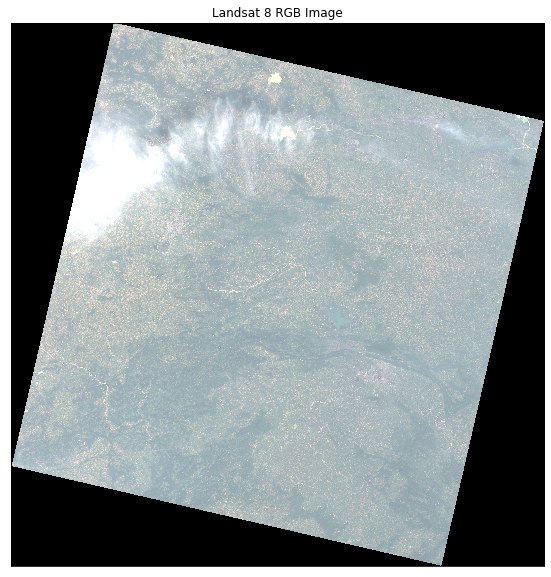

In [17]:
# Plot red, green, and blue bands, respectively
ep.plot_rgb(arr_st, rgb=(2, 1, 0), stretch=True, title="Landsat 8 RGB Image")
plt.show()


### Plot Color Infrared (CIR) Composite Image

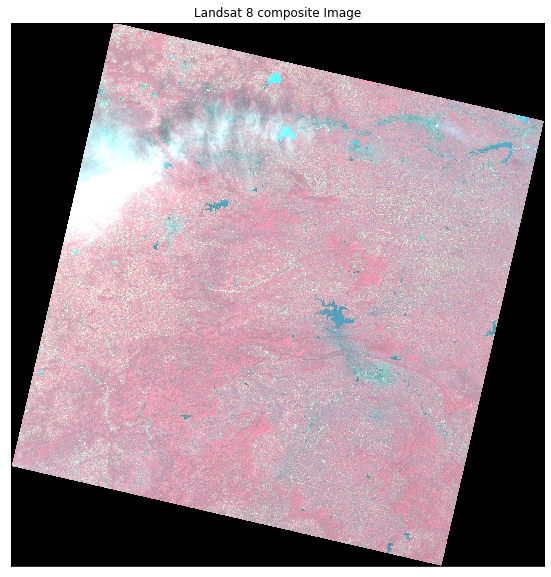

In [18]:
# Plot near-infrared (NIR), red, and green bands,  respectively
ep.plot_rgb(arr_st, rgb=(3, 2, 1), stretch=True, title="Landsat 8 composite Image")
plt.show()


## Plot ROI on full image
To plot the roi, the raster data(full image) and the region of interset need to be in the same Coordinate Reference System (CRS). 

In [19]:
# Reproject boundary to match CRS of the Landsat images
with rasterio.open(landsat_bands_data_path_sorted[0]) as src:
    raster_profile = src.profile
    aoi_points= aoi.to_crs(raster_profile["crs"])


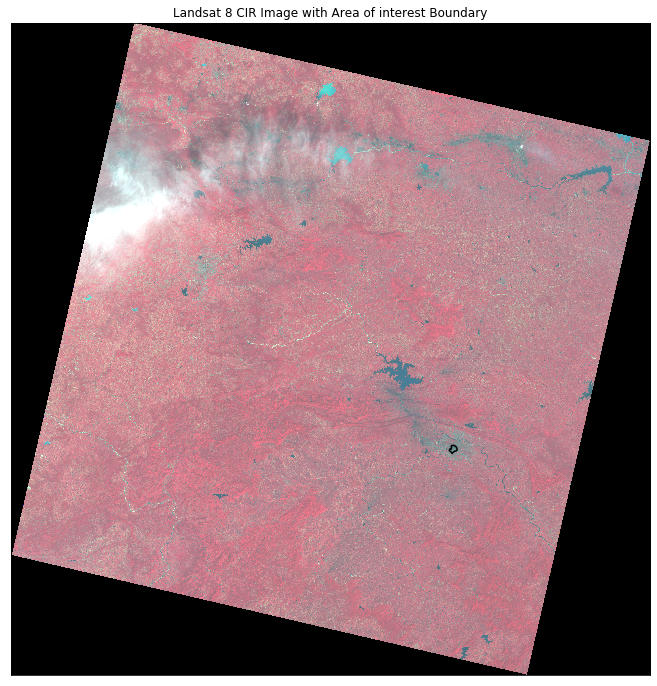

In [20]:
# Create raster extent for the plot
extent = plotting_extent(arr_st[0], raster_profile["transform"])

#Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot boundary with high zorder for contrast
aoi_points.boundary.plot(ax=ax, color="black", zorder=10)

# Plot CIR image using the raster extent
ep.plot_rgb(arr_st,rgb=(3, 2, 1),ax=ax,stretch=True,extent=extent,str_clip=0.5,title="Landsat 8 CIR Image with Area of interest Boundary",)
#plot bounding box over area of interest 



plt.show()

## Crop each band of all the landsat 8  images 


In [21]:
#creat an ouput folder
output_folder_name='landsat8_roi'
output_folder_path=os.path.join(os.getcwd(),output_folder_name)
os.makedirs(output_folder_path, exist_ok=True)

# Read input data folder
input_folder_name="data_l8"
input_data_path=os.path.join(os.getcwd(), input_folder_name) 
land8_path=glob(os.path.join(input_data_path, 'L*'))#input folder path


progess_bar= tqdm_notebook(land8_path, desc='Cropping')

for path in progess_bar:
    
    #input path of image to be cropped
    input_image_path=glob(os.path.join(path, '*.TIF'))
    
    #read meata data path
    metadata_path=glob(os.path.join(path, '*MTL.txt'))[0]
    
    ##output folder
    folder_name=os.path.split(path)[-1] # get the name of current folder
    # Make a folder with the same name in ouput folder.
    dst_folder = os.path.join(output_folder_name, folder_name)
    os.makedirs(dst_folder, exist_ok=True)
    
    
#     #copy the metadata from source to destination.
#     metadata_name=os.path.split(metadata_path)[-1]
#     shutil.copy(metadata_path, os.path.join(dst_folder, metadata_name))
    
    # cropping all bands from respective folder
    cropped_band_path = es.crop_all(input_image_path, output_dir= dst_folder, geoms=aoi_points, overwrite=True)
    
    
    #copy the metadata from source to destination.
    metadata_name=os.path.split(metadata_path)[-1]
    shutil.copy(metadata_path, os.path.join(dst_folder, metadata_name))
    

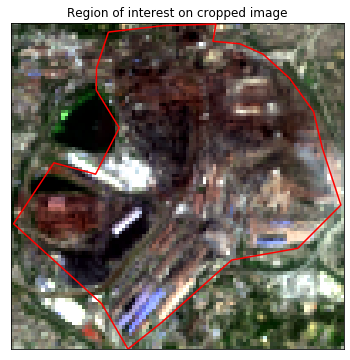

In [22]:
##plot region of interest on cropped image
cropped_band_path=glob("landsat8_roi/LC08_L1TP_140044_20181008_20181029_01_T1/*.TIF")

cropped_band_path_sorted=sorted(cropped_band_path, key=(lambda x:sort(x) ))


cropped_array, array_raster_profile = es.stack(cropped_band_path_sorted[:4], nodata=-9999)
crop_extent = plotting_extent(cropped_array[0], array_raster_profile["transform"]) 

# Plotting the cropped image
fig, ax = plt.subplots(figsize=(12, 6))
aoi_points.boundary.plot(ax=ax, color="red", zorder=10)

ep.plot_rgb(cropped_array,rgb=(2, 1, 0), ax=ax,stretch=True,extent=crop_extent,title="Region of interest on cropped image",)
plt.show()


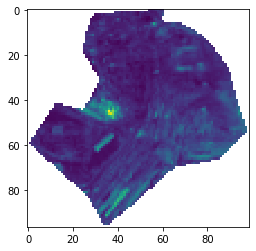

In [23]:
##Plot extact region of interest

with rasterio.open(cropped_band_path_sorted[0]) as src:
    out_image, out_transform = rasterio.mask.mask(src, aoi_points.geometry,crop=True,filled=False,)
    profile = src.profile
#     out_meta = src.meta.copy()
#     out_meta.update({"driver": "GTiff",
#                  "height": out_image.shape[1],
#                  "width": out_image.shape[2],
#                  "transform": out_transform})
show(out_image)
plt.show()   

In [24]:
profile 

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 99, 'height': 97, 'count': 1, 'crs': CRS.from_epsg(32645), 'transform': Affine(30.0, 0.0, 416355.0,
       0.0, -30.0, 2521605.0), 'tiled': False, 'interleave': 'band'}

# Calculates top of atmosphere reflectance and brightness temperature for Landsat 8
Calculate the TOA reflectance for band B4 and B5 and brightness temperature for band 10


In [25]:
creation_options = {'nodata': 0,
                    'compress': 'deflate',
                    'predict': 2}

processes = 4
rescale_factor = 55000
dtype = 'uint16'

In [26]:
#creat an ouput folder for TOA and brightness temperature
output_folder_name='landsat8_roi_toa'
output_folder_path=os.path.join(os.getcwd(),output_folder_name)
os.makedirs(output_folder_path, exist_ok=True)

# Read input data folder
input_folder_name="landsat8_roi"
input_data_path=os.path.join(os.getcwd(), input_folder_name) 
land8_roi_path=glob(os.path.join(input_data_path, 'L*'))#input folder path

for path in land8_roi_path:
    
    #get the current folder name
    folder_name=os.path.split(path)[-1]
        
    ##make folder within folder
    
    folder_name=os.path.split(path)[-1] # get the name of current folder
    dst_folder = os.path.join(output_folder_name, folder_name)# Make a folder with the same name in ouput folder.
    os.makedirs(dst_folder, exist_ok=True) ##create folder
 
        
    #copy the metadata from source to destination.
    #read meata data path
    metadata_path=glob(os.path.join(path, '*MTL.txt'))[0]
    metadata_name=os.path.split(metadata_path)[-1]
    #shutil.copy(metadata_path, os.path.join(dst_folder, metadata_name))
    
    #iterate over band4, band5 and band10
    for band in [4,5,10]:

         #Use glob to find the required band 

        src_path = glob(os.path.join(path, '*B[{}]*'.format(band)))
        
        dst_path = os.path.join(dst_folder, 'TOA_B{}.TIF'.format(band))
        
        if band !=10: #calulate toa reflectance for band4 and band5
            
            # this code skips the ones that were already processed.
            if not os.path.exists(dst_path): 

                # Use the `rio-toa` module for reflectance.
                reflectance.calculate_landsat_reflectance(src_path, metadata_path, 
                                                          dst_path,
                                                          rescale_factor=rescale_factor, 
                                                          creation_options=creation_options,
                                                          bands=[band], dst_dtype=dtype,
                                                          processes=processes, pixel_sunangle=True)
                
        else:## Conversions of radians to at-sensor temperature
                
                brightness_temp.calculate_landsat_brightness_temperature(src_path[0], 
                                                                     metadata_path,dst_path,
                                                                     temp_scale="C",
                                                                     creation_options=creation_options,
                                                                     band=band,
                                                                     dst_dtype=dtype, 
                                                                     processes=processes)


    # copy the metadata from source to destination.
    
    shutil.copy(metadata_path, os.path.join(dst_folder, metadata_name))


## Land Surface Temperature Calculation

In [27]:
def land_surface_temp(BT,red, nir):
    """Calculate land surface temperature of Landsat 8
    
    temp = BT/1 + l * (BT /p) * ln(e)
    
    BT = At Satellite temperature (brightness)
    l= wavelength of emitted radiance (μm)
    
    where p = h * c / s (1.439e-2 mK)
    
    h = Planck's constant (Js)
    s = Boltzmann constant (J/K)
    c = velocity of light (m/s)
    """
    l=10.895
    h = 6.626e-34
    s = 1.38e-23
    c = 2.998e8
    p = (h * c / s) * 1e6
    
    ##NDVI calculation
    ndvi=np.where((nir-red)/(nir+red)>1,0,(nir-red)/(nir+red))
   
    ##Calculating the Proportion of Vegetation
    NDVIv = 0.5 ## ndvi value for vegetation
    NDVIs = 0.2 ## ndvi value for soil
    
    Pv = ((ndvi - NDVIs) / (NDVIv - NDVIs))**2
    
    ##Method 1
    ##Caculating land surface emissivity
    vegetation_emissivity=0.973
    soil_emissivity=0.966
    
    C=0.005 #represents the surface roughness (C = 0 for homogenous and flat surfaces) 
    
    e=np.zeros(shape=((nir.shape[0], nir.shape[1]))) ##initialize the emissivity with zeros
    
    for i in range(nir.shape[0]):
        for j in range(nir.shape[1]):
            
            if ndvi[i][j]<NDVIs:
                e[i][j]=soil_emissivity
                
            elif  NDVIs <=ndvi[i][j] <=NDVIv:
                e[i][j]=vegetation_emissivity*Pv[i][j] +soil_emissivity*(1-Pv[i][j])+C
            else:
                e[i][j]=soil_emissivity+C
    
    
##Method 2 
##Caculating land surface emissivity
#     Pv = (NDVI - NDVI.min() / NDVI.max() - NDVI.min())**2
#     e = 0.004 * Pv + 0.986
    
    return BT / 1 + l * (BT / p) * np.log(e)

def read_image(path): #function to read image
    
    image=rasterio.open(path)
    profile = image.profile
    return image.read(1), profile

In [28]:
#creat an ouput folder for LST image
output_folder_name="landsat8_roi_lst"
output_folder_path=os.path.join(os.getcwd(),output_folder_name)
os.makedirs(output_folder_path, exist_ok=True)

# Read input data folder of top of atmosphere reflectance and brightness temperature
input_folder_name='landsat8_roi_toa'
input_data_path=os.path.join(os.getcwd(), input_folder_name) 
land8_toa_path=glob(os.path.join(input_data_path, 'L*'))#input folder path


progess_bar= tqdm_notebook(land8_toa_path, desc='LST Calculation')
for path in sorted(progess_bar):
    
    
    folder_name=os.path.split(path)[-1] # get the name of current folder
    dst_folder = os.path.join(output_folder_name, folder_name)# Make a folder with the same name in ouput folder.
    os.makedirs(dst_folder, exist_ok=True) ##create folder
 
    
    
    image_path=glob(os.path.join(path, '*.TIF'))
    image_path_sorted=sorted(image_path, key=(lambda x:sort(x)))
    
    red_band=image_path_sorted[0] 
    nir_band=image_path_sorted[1]
    tir_band=image_path_sorted[2]
    
    #read band 
    red=read_image(red_band)[0]
    nir=read_image(nir_band)[0]
    tir=read_image(tir_band)[0]
    
    #land surface image
    lst=land_surface_temp(tir,red, nir)
    
    image_save_path=os.path.join(dst_folder,image_path[0].split('_')[-5]+"_LST.TIF")
    profile=read_image(red_band)[1]
    profile.update({'dtype': 'float64'})
    with rasterio.open(image_save_path, 'w', **profile) as dst:
        dst.write(lst, 1)
    
    

## LST Trend analysis

LAND SURFACE TEMPERATURE PLOT DATEWISE(Temperature in Celsius scale )


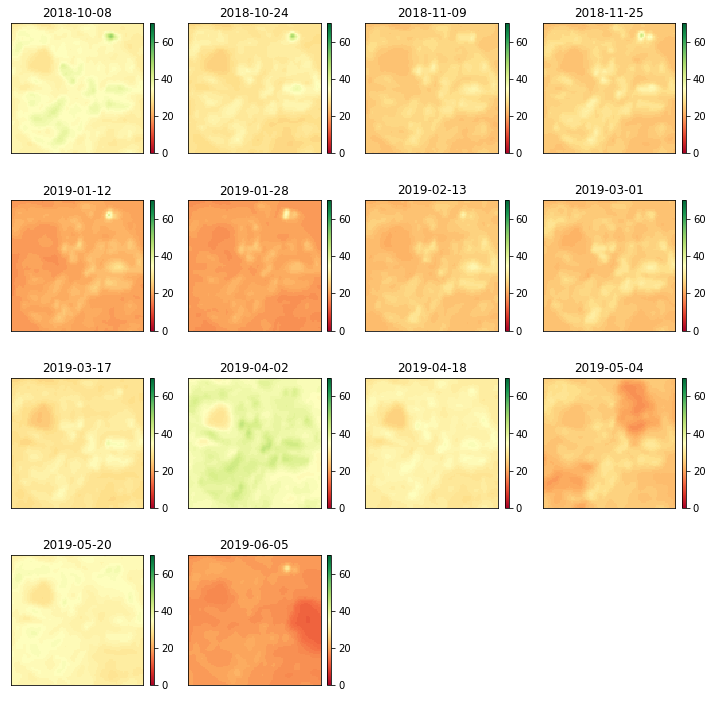

In [29]:
#input path for image
input_folder_name="landsat8_roi_lst"
input_folder_path=os.path.join(os.getcwd(), input_folder_name) 
land8_roi_lst_path=glob(os.path.join(input_folder_path, 'L*'))##read all the folder


lst_image_list=[] # Lst image path
for path in sorted(land8_roi_lst_path):
    image_path=glob(os.path.join(path, '*.TIF'))[0]
    lst_image_list.append(image_path)
    

image_acquired_date=[] # image acquired date 
for i in lst_image_list:
    x=i.split('/')[-1].split('_')[0]
    yyyy=x[:4]
    mm=x[4:6]
    dd=x[6:8]
    date=yyyy+'-'+mm+'-'+dd
    image_acquired_date.append(date)

    
#create image stack
# Create image stack and apply nodata value for Landsat
arr_lst, meta = es.stack(lst_image_list)
    
#plot land surface temperature image
print("LAND SURFACE TEMPERATURE PLOT DATEWISE(Temperature in Celsius scale )")
ep.plot_bands(arr_lst, cmap="RdYlGn",title=image_acquired_date,cols=4, scale=False, vmin=0, vmax=70, figsize=(10, 10))
plt.show()


LAND SURFACE TEMPERATURE(Temperature in Celsius scale ) PLOT OF REGION OF INTEREST


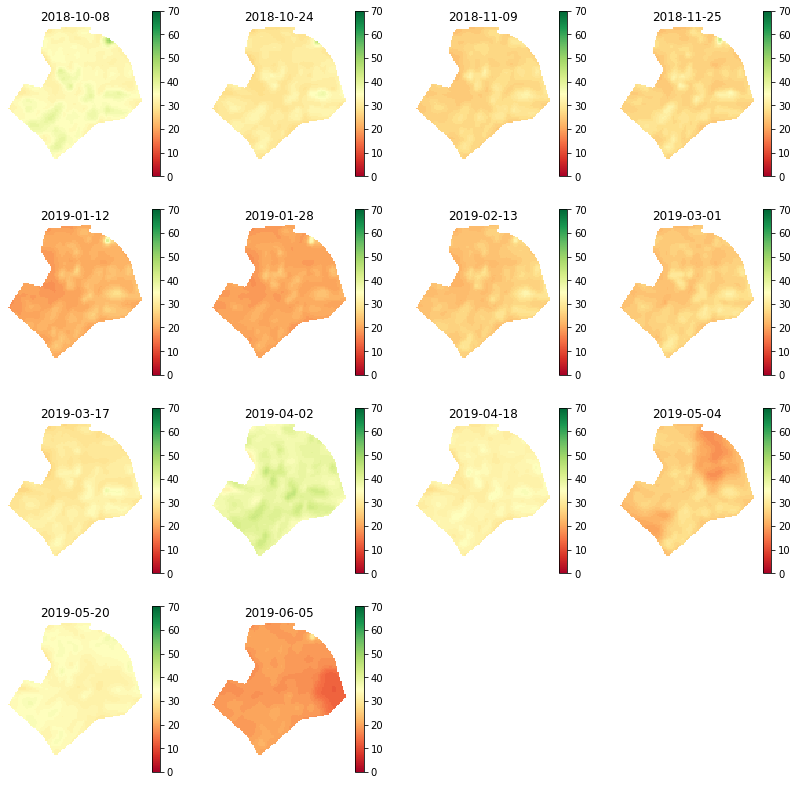

In [30]:
##Plot extact region of interest
print("LAND SURFACE TEMPERATURE(Temperature in Celsius scale ) PLOT OF REGION OF INTEREST")
actual_image=[]
mean_temperature=[]
for i in lst_image_list:
    lst=rasterio.open(i)

    out_image, out_transform =rasterio.mask.mask(lst,aoi_points.geometry, crop=True,filled=False,)
    actual_image.append(out_image[0])
    mean_temperature.append(out_image[0].mean())
    
fig = plt.figure(figsize=(14, 14))
ax = []  # ax enables access to manipulate each of subplots
rows, columns=4,4
for i in range(14):
    #index=np.random.randint(1,n)
    img= actual_image[i] ##reshape input data to rgb image
    ax.append( fig.add_subplot(rows, columns, i+1) ) # create subplot and append to ax
    ax[-1].set_title(image_acquired_date[i])  # set class
    plt.axis("off")
    plt.imshow(img, cmap=plt.cm.RdYlGn,vmin=0,vmax=70)
    plt.colorbar()
#plt.subplots_adjust(wspace=0.1,hspace=0.5,)
plt.show()  # finally, render the plot

In [31]:
layout={"title":"Mean LST trend","xaxis_title":"Date","yaxis_title":"Temperature(in celcius)"}
    
go.Figure(go.Scatter(x=image_acquired_date, y=mean_temperature),layout=layout) #plot time series graph